## Importing Libraries

In [22]:
import subprocess
import os
import site
import sys
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def install(package, target):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--target", "./"+target])
install("kmodes==0.11.1", "kmodes")
site.addsitedir(str(os.path.abspath('./')+'/kmodes'))

In [3]:
from kmodes.kmodes import KModes

In [4]:
#
#	k-prototypes.py
#
#       Run k-prototypes on (netflow) data, which inspiration (pandas) from Ed Henry
#
#	code: https://github.com/nicodv/kmodes
#
#	See "A New Approach to Data Driven Clustering", Azran, A., et al. 
#	http://mlg.eng.cam.ac.uk/zoubin/papers/AzrGhaICML06.pdf
#
#	See also
#
#	"Extensions to the k-Means Algorithm for Clustering Large Data Sets
#	with Categorical Values", Zhexue Huang
#	http://www.cse.ust.hk/~qyang/537/Papers/huang98extensions.pdf
#

#       imports
#
import sys
import time
import numpy as np
import pandas as pd
from   kmodes import kmodes

In [5]:
from   kmodes import kprototypes

#       globals
#
DEBUG         = 2                               # set to 1 to debug, 2 for more
verbose       = 0                               # kmodes debugging
nrows         = 30                              # number of rows to read (resources)

In [6]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [7]:
spark_df=spark.sql("""select * from vzw_uda_dev_rdgtbls.Customer_Intent_segmentation_v5""")

In [8]:
df=spark_df.toPandas()

/grid/6/tmp/yarn-local/usercache/ksaravankumar/appcache/application_1630511478381_696040/container_e29_1630511478381_696040_01_000001/pyspark.zip/pyspark/sql/pandas/conversion.py:88: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Arrow legacy IPC format is not supported in PySpark, please unset ARROW_PRE_0_15_IPC_FORMAT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.


## Feature engineering

In [9]:
# Dropped unwanted columns
cols_to_drop = ['rebate_ind',
            'ptp_ind', 'ptp1_eff_ind', 'ptp2_eff_ind', 'ptp_hold_ind',
       'ptp_broken_ind', 'ptp_kept_ind','ACCT_STATUS_IND','curr_plan',
        'limited_plan_bill_hike', 'overage_ind',
       'vzup_enrolled']


In [10]:
def const_impute(df, features_list, constval):
    '''Constant imputer.'''
    df = df.na.fill(constval, features_list)
    return df

In [11]:
minus99_imputes=['plan_change_recency']

In [12]:
data_df = spark_df.drop(*cols_to_drop)

data_df = const_impute(data_df, minus99_imputes, -99)

In [13]:
data_df = data_df.na.fill('NA').na.fill(0).na.fill(0.0)

In [14]:
from pyspark.sql.functions import col, collect_list, current_date, current_timestamp, last_day, lit, when, to_date, max as udf_max, min as udf_min, sum as udf_sum, count, date_format, ntile, udf, unix_timestamp

In [15]:
cols_manipulated=['LINE_IN_SVC_CNT','ACCT_TENURE']

In [16]:
data_df = data_df.withColumn("SINGLE_LINE_CUSTOMER", when(col("LINE_IN_SVC_CNT")==1,1).otherwise(0)). \
    withColumn("LINE_IN_SVC_2PLUS", when(col("LINE_IN_SVC_CNT")>=2,1).otherwise(0)). \
    withColumn("LINE_IN_SVC_IND", when(col("LINE_IN_SVC_CNT")<3,0).when( (col("LINE_IN_SVC_CNT")>=3) & (col("LINE_IN_SVC_CNT")<=8),1).otherwise(2)). \
    withColumn("ACCT_TENURE_5YEAR", when(col("ACCT_TENURE")>=60,1).otherwise(0)). \
    withColumn("ACCT_TENURE_IND", when( (col("ACCT_TENURE")>=0) & (col("ACCT_TENURE")<12),1).when( (col("ACCT_TENURE")>=12) & (col("ACCT_TENURE")<60),2).when( (col("ACCT_TENURE")>=60) & (col("ACCT_TENURE")<240),3).otherwise(4)). \
    withColumn('loan_status_ind', when(data_df['loan_status_ind'] == 'NA', 'OT').otherwise(data_df['loan_status_ind']))

In [17]:
data_df = data_df.drop(*cols_manipulated)

In [18]:
cat_col=['equip_type_changed','loan_status_ind']

In [19]:
import pyspark.sql.functions as F

In [20]:
for c in cat_col:
    categ = data_df.select(c).distinct().rdd.flatMap(lambda x:x).collect()
    categ = list(set([i.strip() for i in categ]))
    exprs = [F.when(F.col(c) == cat,1).otherwise(0).alias(str(c + '_' + cat)) for cat in categ]
    data_df = data_df.select(exprs+data_df.columns)
data_df = data_df.drop(*cat_col)

In [21]:
data_df.columns

['loan_status_ind_OT',
 'loan_status_ind_F',
 'loan_status_ind_P',
 'loan_status_ind_B',
 'loan_status_ind_C',
 'loan_status_ind_AA',
 'loan_status_ind_A',
 'equip_type_changed_Android_Apple',
 'equip_type_changed_others',
 'equip_type_changed_Android_iPad',
 'equip_type_changed_Android_wireless',
 'cust_id',
 'acct_num',
 'bill_dt',
 'call_start_dt',
 'equip_purchase_last_7days',
 'equip_purchased_2yrs',
 'equip_owned',
 'days_since_suspended',
 'suspend_ind',
 'voluntary_disconnects',
 'involuntary_disconnects',
 'COLLECTION_IND',
 'bill_hike_ind',
 'eqp_and_service',
 'refund_order',
 'tradein_ind',
 'return_ind',
 'plan_change_recency',
 'plan_change_freq',
 'total_activation',
 'SINGLE_LINE_CUSTOMER',
 'LINE_IN_SVC_2PLUS',
 'LINE_IN_SVC_IND',
 'ACCT_TENURE_5YEAR',
 'ACCT_TENURE_IND']

## Elbow method to determine optimum clusters 

In [23]:
selectCols=['loan_status_ind_OT',
 'loan_status_ind_F',
 'loan_status_ind_P',
 'loan_status_ind_B',
 'loan_status_ind_C',
 'loan_status_ind_AA',
 'loan_status_ind_A',
 'equip_type_changed_Android_Apple',
 'equip_type_changed_others',
 'equip_type_changed_Android_iPad',
 'equip_type_changed_Android_wireless',
 'equip_purchase_last_7days',
 'equip_purchased_2yrs',
 'equip_owned',
 'days_since_suspended',
 'suspend_ind',
 'voluntary_disconnects',
 'involuntary_disconnects',
 'COLLECTION_IND',
 'bill_hike_ind',
 'eqp_and_service',
 'refund_order',
 'tradein_ind',
 'return_ind',
 'plan_change_recency',
 'plan_change_freq',
 'total_activation',
 'SINGLE_LINE_CUSTOMER',
 'LINE_IN_SVC_2PLUS',
 'LINE_IN_SVC_IND',
 'ACCT_TENURE_5YEAR',
 'ACCT_TENURE_IND']

In [25]:
dfo=data_df.select(*selectCols)

In [28]:
dfo=dfo.toPandas()

/grid/6/tmp/yarn-local/usercache/ksaravankumar/appcache/application_1630511478381_696040/container_e29_1630511478381_696040_01_000001/pyspark.zip/pyspark/sql/pandas/conversion.py:88: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Arrow legacy IPC format is not supported in PySpark, please unset ARROW_PRE_0_15_IPC_FORMAT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [29]:
sse={}
for k in range(1,20):
    kmeans=KMeans(n_clusters=k,init='k-means++').fit(dfo)
    sse[k]=kmeans.inertia_

In [30]:
groups=list(sse.keys())
error=list(sse.values())

error_df=pd.DataFrame(list(zip(groups,error)),columns=['groups','error'])
error_df.head(10)

,groups,error
0,1,9.823237e+06
1,2,6.131416e+05
2,3,4.329047e+05
3,4,2.941771e+05
4,5,2.467185e+05
5,6,2.146873e+05
6,7,1.908326e+05
7,8,1.750413e+05
8,9,1.627907e+05
9,10,1.522824e+05


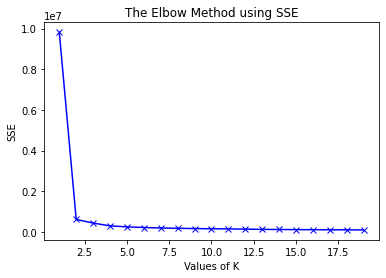

In [31]:
plt.plot(error_df['groups'], error_df['error'], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('SSE')
plt.title('The Elbow Method using SSE')
plt.show()

In [33]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(dfo)
    kmeanModel.fit(dfo)
 
    distortions.append(sum(np.min(cdist(dfo, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / dfo.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(dfo, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / dfo.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [34]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 19.614917451855238
2 : 5.950400389905958
3 : 5.290834287192431
4 : 4.267290155689584
5 : 3.8947935032455785
6 : 3.753884453869948
7 : 3.5372089608388135
8 : 3.436712098651106
9 : 3.429574992281767


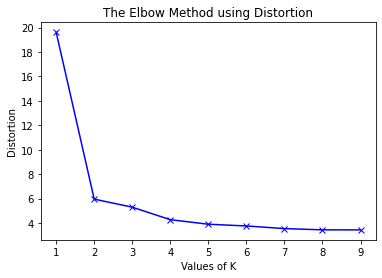

In [35]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [36]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 9823237.44315705
2 : 613141.5909467308
3 : 432904.736865166
4 : 294177.13096260605
5 : 246738.42486462792
6 : 214687.2846289517
7 : 190832.52847011876
8 : 178236.3011279807
9 : 163110.4059738959


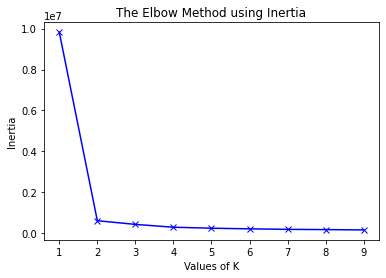

In [37]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

## Clustering

In [38]:
col_names=['loan_status_ind_OT',
 'loan_status_ind_F',
 'loan_status_ind_P',
 'loan_status_ind_B',
 'loan_status_ind_C',
 'loan_status_ind_AA',
 'loan_status_ind_A',
 'equip_type_changed_Android_Apple',
 'equip_type_changed_others',
 'equip_type_changed_Android_iPad',
 'equip_type_changed_Android_wireless',
 'suspend_ind',
 'COLLECTION_IND',
 'bill_hike_ind', 
 'SINGLE_LINE_CUSTOMER',
 'LINE_IN_SVC_2PLUS',
 'LINE_IN_SVC_IND',
 'ACCT_TENURE_5YEAR',
 'ACCT_TENURE_IND']

In [39]:
df1=data_df.select(*selectCols)

In [40]:
df=df1.toPandas()

/grid/6/tmp/yarn-local/usercache/ksaravankumar/appcache/application_1630511478381_696040/container_e29_1630511478381_696040_01_000001/pyspark.zip/pyspark/sql/pandas/conversion.py:88: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Arrow legacy IPC format is not supported in PySpark, please unset ARROW_PRE_0_15_IPC_FORMAT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [41]:
df.dtypes

loan_status_ind_OT                     int32
loan_status_ind_F                      int32
loan_status_ind_P                      int32
loan_status_ind_B                      int32
loan_status_ind_C                      int32
loan_status_ind_AA                     int32
loan_status_ind_A                      int32
equip_type_changed_Android_Apple       int32
equip_type_changed_others              int32
equip_type_changed_Android_iPad        int32
equip_type_changed_Android_wireless    int32
equip_purchase_last_7days              int32
equip_purchased_2yrs                   int64
equip_owned                            int64
days_since_suspended                   int32
suspend_ind                            int32
voluntary_disconnects                  int64
involuntary_disconnects                int64
COLLECTION_IND                         int32
bill_hike_ind                          int32
eqp_and_service                        int64
refund_order                           int64
tradein_in

In [42]:
df.describe()

,loan_status_ind_OT,loan_status_ind_F,loan_status_ind_P,loan_status_ind_B,loan_status_ind_C,loan_status_ind_AA,loan_status_ind_A,equip_type_changed_Android_Apple,equip_type_changed_others,equip_type_changed_Android_iPad,...,tradein_ind,return_ind,plan_change_recency,plan_change_freq,total_activation,SINGLE_LINE_CUSTOMER,LINE_IN_SVC_2PLUS,LINE_IN_SVC_IND,ACCT_TENURE_5YEAR,ACCT_TENURE_IND
count,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000,...,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000,8717.000000
mean,0.073305,0.001262,0.145922,0.000918,0.033268,0.004933,0.740392,0.089136,0.904325,0.005736,...,0.015143,0.019502,-89.035792,0.149937,0.308822,0.212229,0.787427,0.546748,0.670529,2.671217
std,0.260651,0.035503,0.353048,0.030282,0.179347,0.070065,0.438444,0.284957,0.294162,0.075523,...,0.151481,0.267714,32.914276,0.616902,0.843859,0.408910,0.409152,0.534728,0.470048,0.808947
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,-99.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,-99.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,-99.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,10.000000,71.000000,16.000000,9.000000,1.000000,1.000000,2.000000,1.000000,4.000000


In [43]:
df = df.dropna()

In [44]:
for c in col_names:
    df[c] = df[c].astype('category')

In [45]:
categoricals_indicies = []
for col in col_names:
        categoricals_indicies.append(col_names.index(col))

In [46]:
fields = list(col_names)
fields.append('equip_purchase_last_7days')
fields.append('equip_purchased_2yrs')
fields.append('equip_owned')
fields.append('days_since_suspended')
fields.append('plan_change_recency')
fields.append('plan_change_freq')
fields.append('total_activation')
fields.append('eqp_and_service')
fields.append('refund_order')
fields.append('tradein_ind')
fields.append('return_ind')
fields.append('voluntary_disconnects')
fields.append('involuntary_disconnects')

In [47]:
data_cats = df.loc[:,fields]

In [48]:
columns_to_normalize     = ['eqp_and_service','refund_order','return_ind','tradein_ind','equip_purchase_last_7days', 'equip_purchased_2yrs','equip_owned','days_since_suspended','plan_change_recency','plan_change_freq','total_activation']
df[columns_to_normalize] = df[columns_to_normalize].apply(lambda x: (x - x.mean()) / np.std(x))

In [49]:
df.dtypes

loan_status_ind_OT                     category
loan_status_ind_F                      category
loan_status_ind_P                      category
loan_status_ind_B                      category
loan_status_ind_C                      category
loan_status_ind_AA                     category
loan_status_ind_A                      category
equip_type_changed_Android_Apple       category
equip_type_changed_others              category
equip_type_changed_Android_iPad        category
equip_type_changed_Android_wireless    category
equip_purchase_last_7days               float64
equip_purchased_2yrs                    float64
equip_owned                             float64
days_since_suspended                    float64
suspend_ind                            category
voluntary_disconnects                     int64
involuntary_disconnects                   int64
COLLECTION_IND                         category
bill_hike_ind                          category
eqp_and_service                         

In [50]:
data_cats_matrix = data_cats.to_numpy()

In [51]:
init       = 'Huang'                    # init can be 'Cao', 'Huang' or 'random'
n_clusters = 5                          # how many clusters (hyper parameter)
max_iter   = 100                        # default 100

In [52]:
#       get the model
#
kproto = kprototypes.KPrototypes(n_clusters=n_clusters,init=init,verbose=verbose)

In [53]:
#       fit/predict
#
clusters = kproto.fit_predict(data_cats_matrix,categorical=categoricals_indicies)

In [54]:
proto_cluster_assignments = zip(data_cats_matrix,clusters)

In [55]:
clusters

array([1, 4, 4, ..., 4, 4, 1], dtype=uint16)

In [56]:
cluster=clusters.tolist()

In [57]:
selectCols1=[
 'cust_id',
 'acct_num',
 'bill_dt',
 'call_start_dt',
 'loan_status_ind_OT',
 'loan_status_ind_F',
 'loan_status_ind_P',
 'loan_status_ind_B',
 'loan_status_ind_C',
 'loan_status_ind_AA',
 'loan_status_ind_A',
 'equip_type_changed_Android_Apple',
 'equip_type_changed_others',
 'equip_type_changed_Android_iPad',
 'equip_type_changed_Android_wireless',
 'equip_purchase_last_7days',
 'equip_purchased_2yrs',
 'equip_owned',
 'days_since_suspended',
 'suspend_ind',
 'voluntary_disconnects',
 'involuntary_disconnects',
 'COLLECTION_IND',
 'bill_hike_ind',
 'eqp_and_service',
 'refund_order',
 'tradein_ind',
 'return_ind',
 'plan_change_recency',
 'plan_change_freq',
 'total_activation',
 'SINGLE_LINE_CUSTOMER',
 'LINE_IN_SVC_2PLUS',
 'LINE_IN_SVC_IND',
 'ACCT_TENURE_5YEAR',
 'ACCT_TENURE_IND'
]

In [59]:
df3=data_df.select(*selectCols1)

In [60]:
df_auto=df3.toPandas()

/grid/6/tmp/yarn-local/usercache/ksaravankumar/appcache/application_1630511478381_696040/container_e29_1630511478381_696040_01_000001/pyspark.zip/pyspark/sql/pandas/conversion.py:88: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Arrow legacy IPC format is not supported in PySpark, please unset ARROW_PRE_0_15_IPC_FORMAT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [61]:
df_auto.insert(0, "Cluster", cluster, True)

In [62]:
sparkDF=spark.createDataFrame(df_auto) 
sparkDF.registerTempTable("FINAL_TBL")

/grid/6/tmp/yarn-local/usercache/ksaravankumar/appcache/application_1630511478381_696040/container_e29_1630511478381_696040_01_000001/pyspark.zip/pyspark/sql/pandas/conversion.py:289: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Arrow legacy IPC format is not supported in PySpark, please unset ARROW_PRE_0_15_IPC_FORMAT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [63]:
from pyspark.sql import HiveContext
from pyspark.sql.window import Window
import os
import argparse
import sys
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.context import SparkContext
import warnings

In [64]:
score_model_id='Customer_Intent_v1'
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName(score_model_id+'_ETL_preparation').enableHiveSupport().getOrCreate()
#hive_context = HiveContext(spark.sparkContext)
sc =SparkContext.getOrCreate()
hiveContext = HiveContext(sc)

In [65]:
hiveContext.sql("drop table if exists vzw_uda_dev_rdgtbls.Customer_Intent_segmentation_cluster_kprototype_v4")
hiveContext.sql("create table vzw_uda_dev_rdgtbls.Customer_Intent_segmentation_cluster_kprototype_v4 as select * from FINAL_TBL")

DataFrame[]

### Trying Inertia and Distortion on sample dataset

In [1]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('Mall_Customers.csv')

In [4]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.shape

(200, 5)

In [6]:
X = df.iloc[:, [3, 4]].values

In [7]:
X.shape

(200, 2)

In [8]:
sse={}
for k in range(1,20):
    kmeans=KMeans(n_clusters=k,init='k-means++').fit(X)
    sse[k]=kmeans.inertia_

In [9]:
groups=list(sse.keys())
error=list(sse.values())

error_df=pd.DataFrame(list(zip(groups,error)),columns=['groups','error'])
error_df.head(10)

,groups,error
0,1,269981.280000
1,2,181363.595960
2,3,106348.373062
3,4,73679.789039
4,5,44448.455448
5,6,37271.886237
6,7,30241.343618
7,8,25062.433793
8,9,21850.165283
9,10,19787.670555


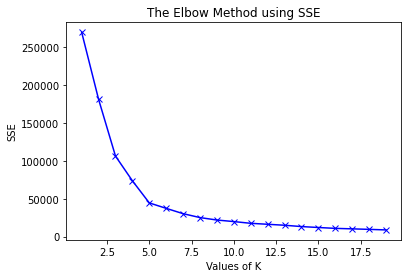

In [10]:
plt.plot(error_df['groups'], error_df['error'], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('SSE')
plt.title('The Elbow Method using SSE')
plt.show()

### What is distortion and Inertia?

Distortion is the average of the euclidean squared distance from the centroid of the respective clusters. Inertia is the sum of squared distances of samples to their closest cluster centre. 

In [11]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 31.11956466178274
2 : 26.9728389711296
3 : 19.49852756350156
4 : 16.513850087397763
5 : 13.020126350791745
6 : 12.10048793253976
7 : 11.282330175537833
8 : 9.957146987058685
9 : 9.302355195199265


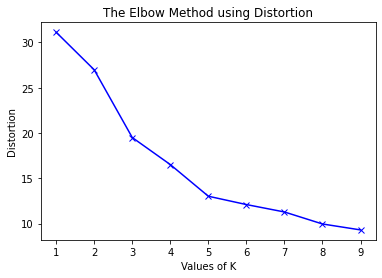

In [12]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [13]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 269981.28000000014
2 : 181363.59595959607
3 : 106348.37306211119
4 : 73679.78903948837
5 : 44448.45544793369
6 : 37265.86520484345
7 : 30227.60651315203
8 : 25007.38394731206
9 : 21794.885609098194


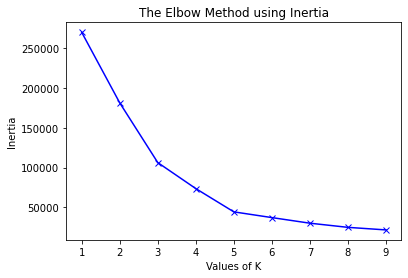

In [14]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [15]:
clusterer = KMeans(n_clusters=7, random_state=10)
cluster_labels = clusterer.fit_predict(X)
print(cluster_labels)

[0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0
 4 0 4 0 4 0 3 0 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 3 5 6 5 6 5
 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1]


In [16]:
range_n_clusters = [3, 4, 5, 6, 7, 8, 9, 10]

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 3 The average silhouette_score is : 0.46761358158775435
For n_clusters = 4 The average silhouette_score is : 0.4931963109249047
For n_clusters = 5 The average silhouette_score is : 0.553931997444648
For n_clusters = 6 The average silhouette_score is : 0.5376203956398481
For n_clusters = 7 The average silhouette_score is : 0.5270287298101395
For n_clusters = 8 The average silhouette_score is : 0.4572211842776841
For n_clusters = 9 The average silhouette_score is : 0.45872989167156364
For n_clusters = 10 The average silhouette_score is : 0.4467356774401869


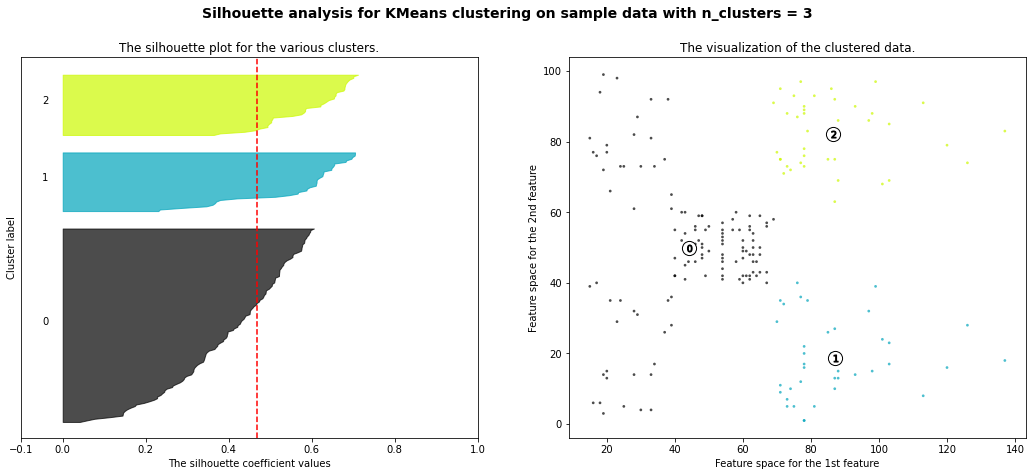

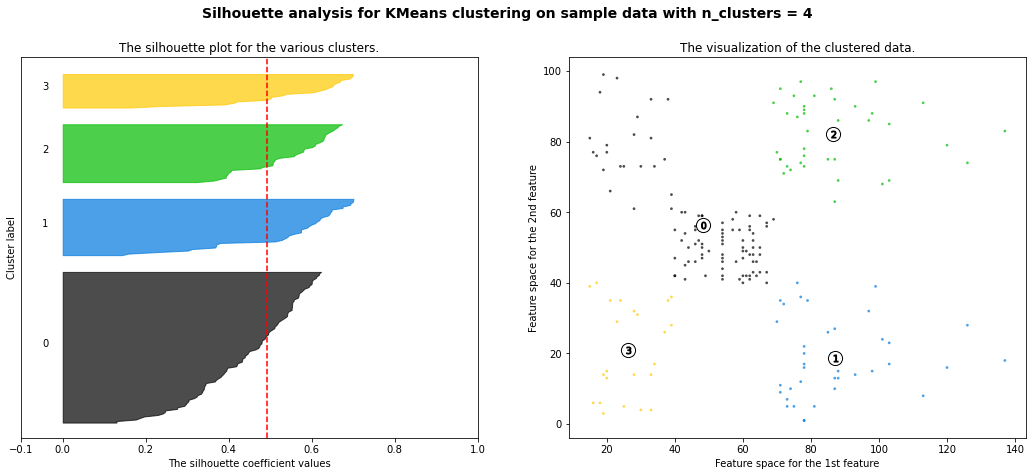

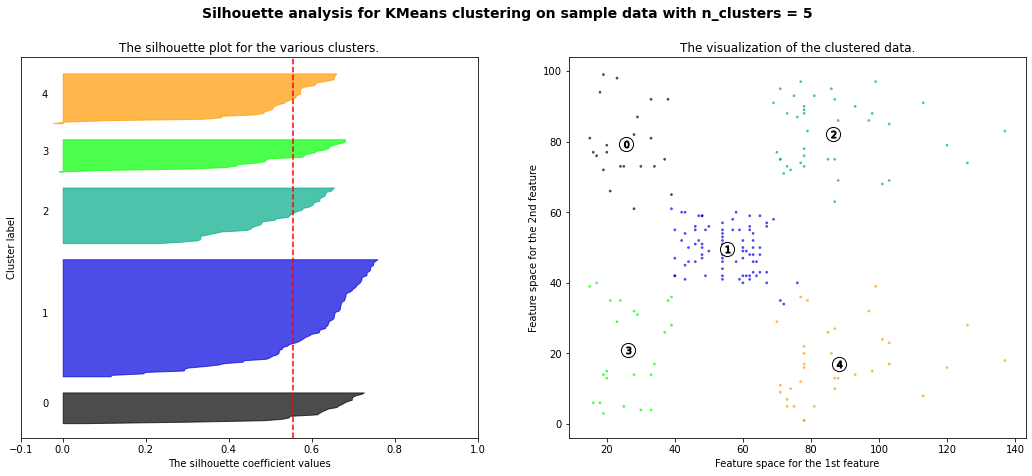

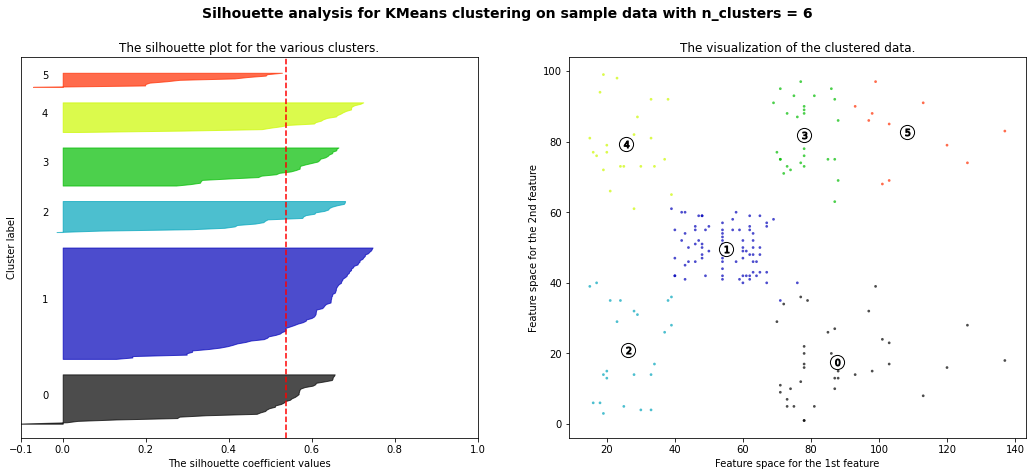

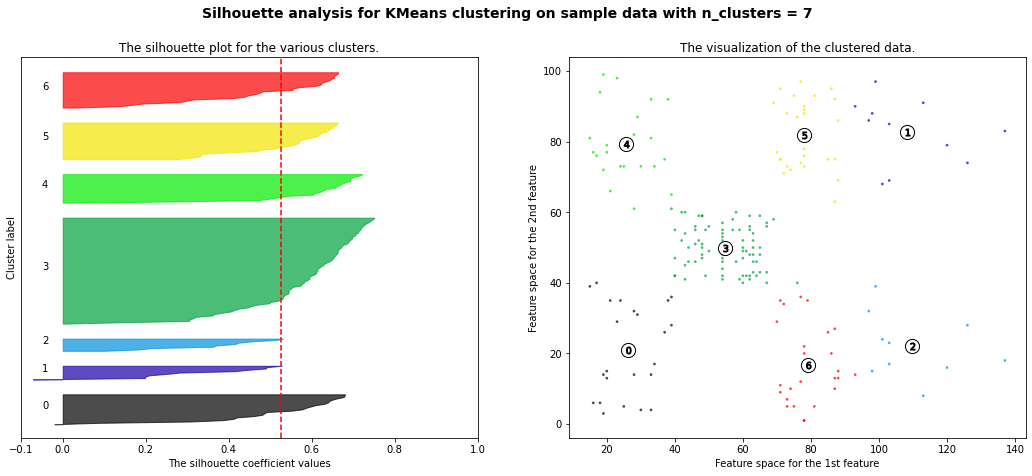

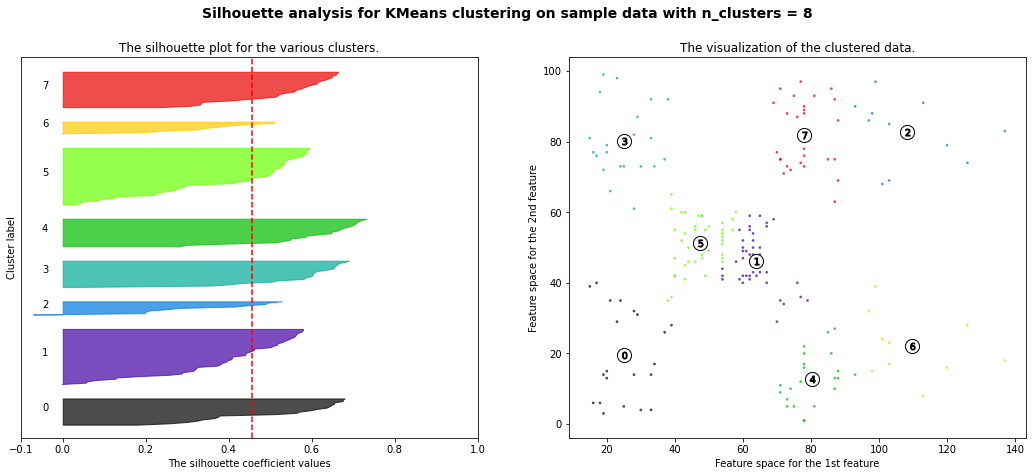

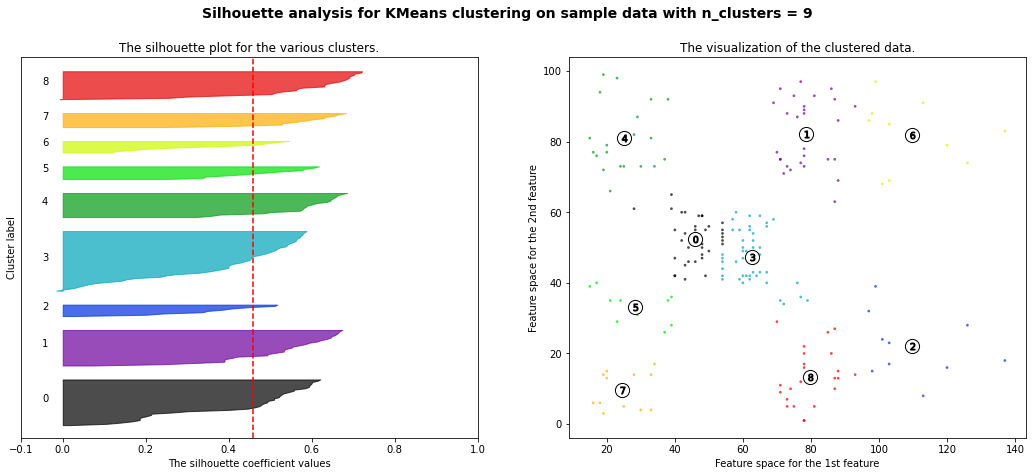

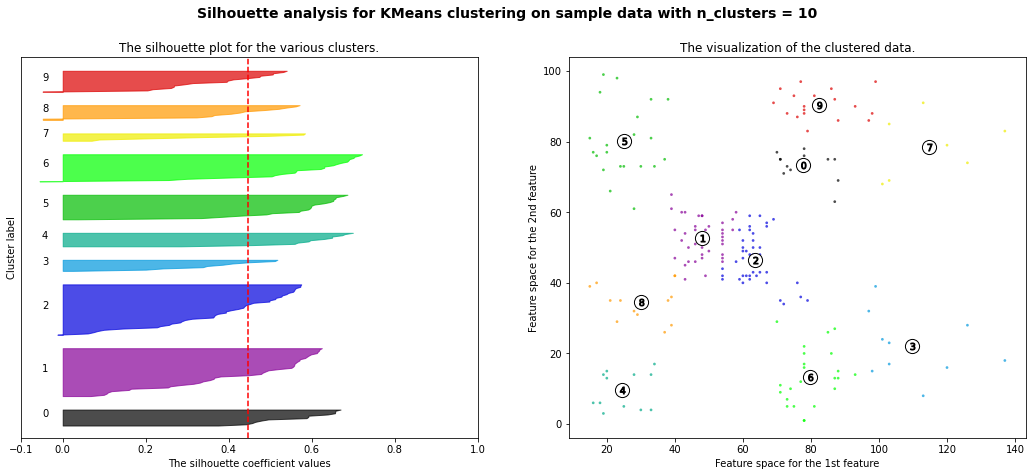

In [21]:
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()